
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries under a climate change scenario (future AWTs occurrence probability)

inputs required: 
  * Historical DWTs (for plotting)
  * Historical wave families (for plotting)
  * Synthetic DWTs climate change
  * Historical intradaily hydrograph parameters  
  * TCs waves
  * Fitted multivariate extreme model for the waves associated to each DWT

  
in this notebook:
  * Generate synthetic time series of wave conditions   
  * Validate the synthetic waves by means of mean distributions


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [4]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('ROI_CC_S5')


# climate emulator simulation modified path
p_S5_CE_sims = op.join(db_S5.paths.site.EXTREMES.climate_emulator, 'Simulations')


In [6]:
# --------------------------------------
# Load data for climate emulator simulation climate change: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db_S5.Load_ESTELA_DWT_sim() # DWTs climate change

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each DWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



In [7]:
# solve first 10 DWTs simulations

DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))
#DWTs_sim = DWTs_sim.isel(time=slice(0,365*40+10), n_sim=slice(0,1))

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 14610)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 2039-12-31 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1



## Climate Emulator - Simulation

In [16]:
# --------------------------------------
# Climate Emulator extremes model fitting

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# set a new path for S5 simulations
CE.Set_Simulation_Folder(p_S5_CE_sims, copy_WAVES_noTCs = False)  # climate change waves (no TCs) not simulated, DWTs have changed


    
# optional: list variables to override distribution to empirical
#CE.sim_icdf_empirical_override = ['sea_Hs_31',
#                                  'swell_1_Hs_1','swell_1_Tp_1',
#                                  'swell_1_Hs_2','swell_1_Tp_2',]

# set simulated waves min-max filter
CE.sim_waves_filter.update({
    'hs': (0, 8),
    'tp': (2, 25),
    'ws': (0, 0.06),
})


In [18]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)

    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})

    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))
    
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 4318/4318 [00:00<00:00, 26534.44it/s]



## Climate Emulator Simulation Validation

In [19]:
# --------------------------------------
# Select Simulation to plot (without Climate Change)
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim_sinCC, TCs_sim_sinCC, WVS_upd_sinCC = CE.LoadSim(n_sim = n_sim_DWTs)

# only one climate emulator simulation
WVS_sim_sinCC = WVS_sim_sinCC.isel(n_sim = n_sim_CE)
TCs_sim_sinCC = TCs_sim_sinCC.isel(n_sim = n_sim_CE)
WVS_upd_sinCC = WVS_upd_sinCC.isel(n_sim = n_sim_CE)


#----------------------------------------------------------
# Poner NaN en WVS_upd_E donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
for var in vars:
    WVS_upd_sinCC[var] = WVS_upd_sinCC[var].where(WVS_upd_sinCC[var]!=0.00, np.nan)


#----------------------------------------------------------    
# select data
WVS_fit_p = CE.WVS_MS
WVS_sim_p_sinCC = WVS_upd_sinCC  # with simulated TCs

In [20]:
# Select Simulation to plot (with Climate Change)
CE.Set_Simulation_Folder(p_S5_CE_sims)


# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# only one climate emulator simulation
WVS_sim = WVS_sim.isel(n_sim = n_sim_CE)
TCs_sim = TCs_sim.isel(n_sim = n_sim_CE)
WVS_upd = WVS_upd.isel(n_sim = n_sim_CE)


#----------------------------------------------------------
# Poner NaN en WVS_upd_E donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
for var in vars:
    WVS_upd[var] = WVS_upd[var].where(WVS_upd[var]!=0.00, np.nan)


#----------------------------------------------------------    
# select data
WVS_sim_p = WVS_upd  # with simulated TCs


## Climate Emulator Validation: Waves Families Variables

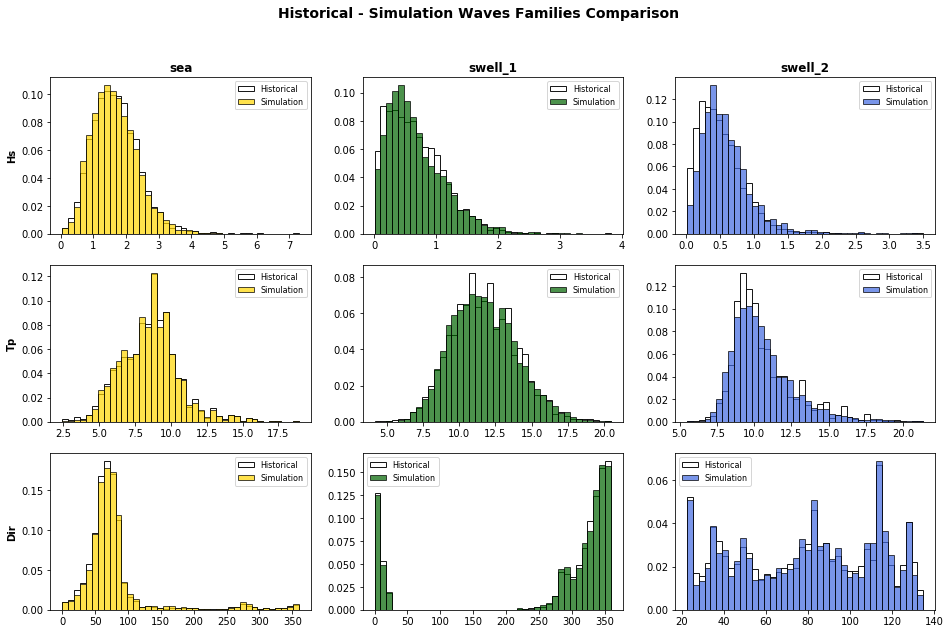

In [21]:
# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit_p, WVS_sim_p);



## Climate Emulator Validation: Hs families

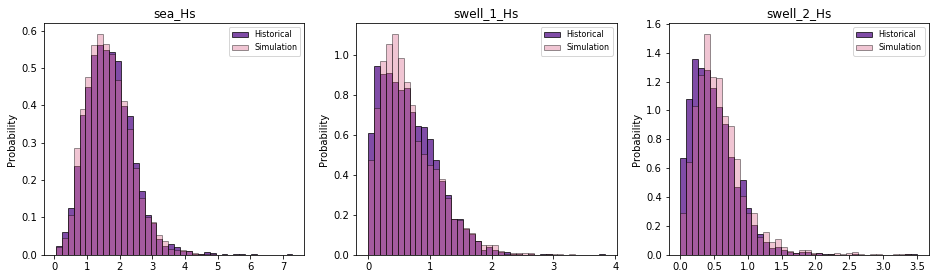

In [29]:
# waves families Hs
vvs = ['sea_Hs', 'swell_1_Hs', 'swell_2_Hs']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


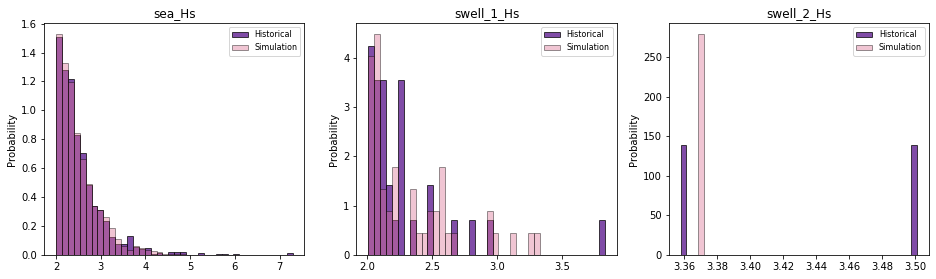

In [30]:
# plot selection
vns_lims = {
    'sea_Hs':(2, 30),
    'swell_1_Hs':(2, 30),
    'swell_2_Hs':(3, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


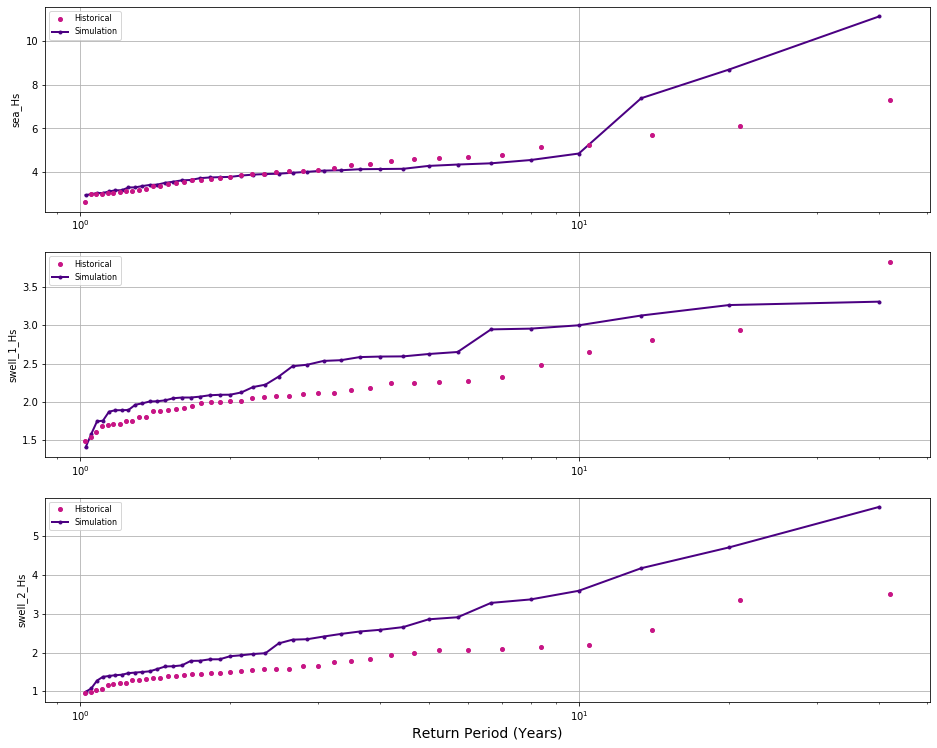

In [25]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


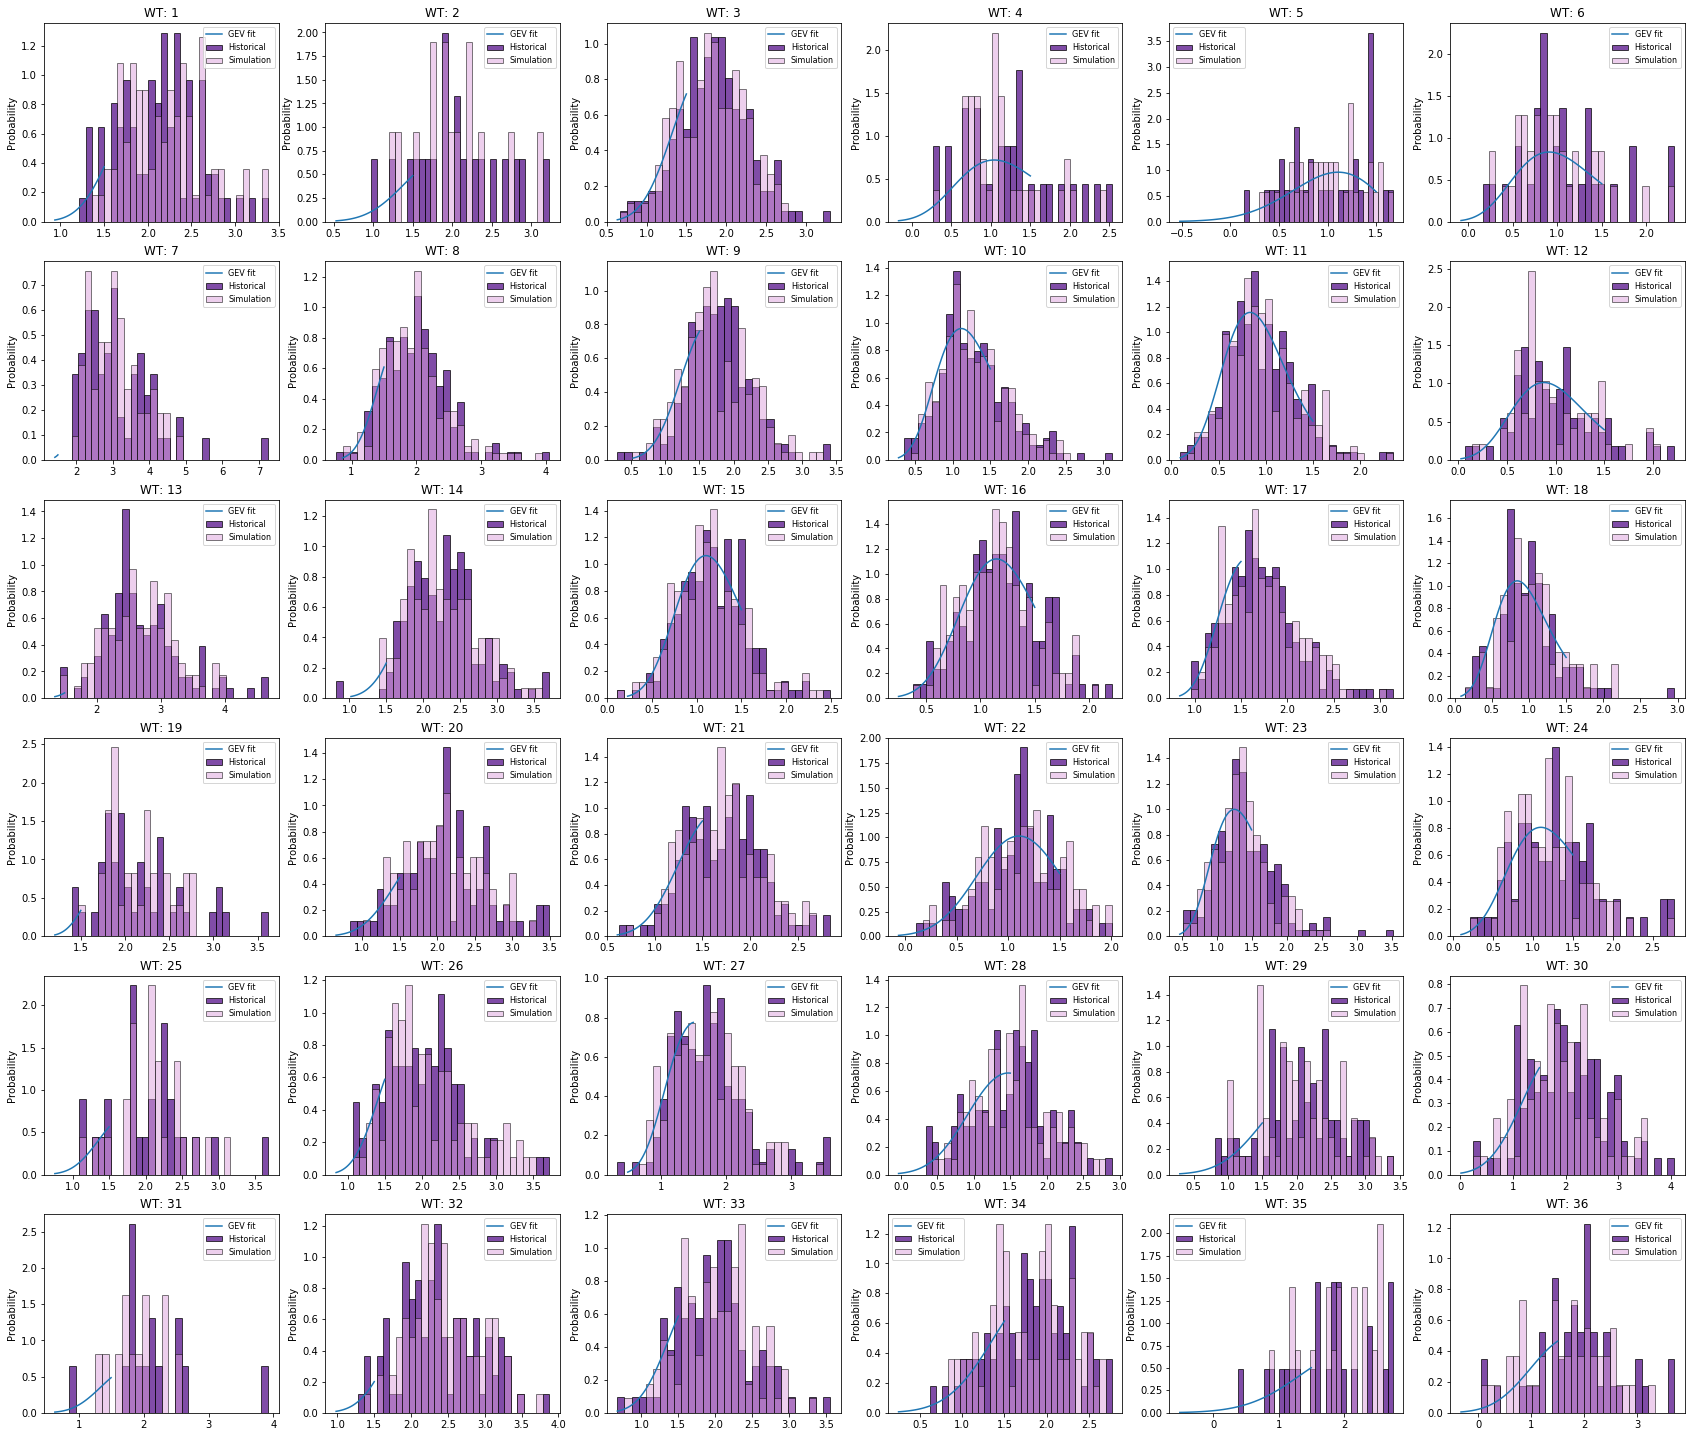

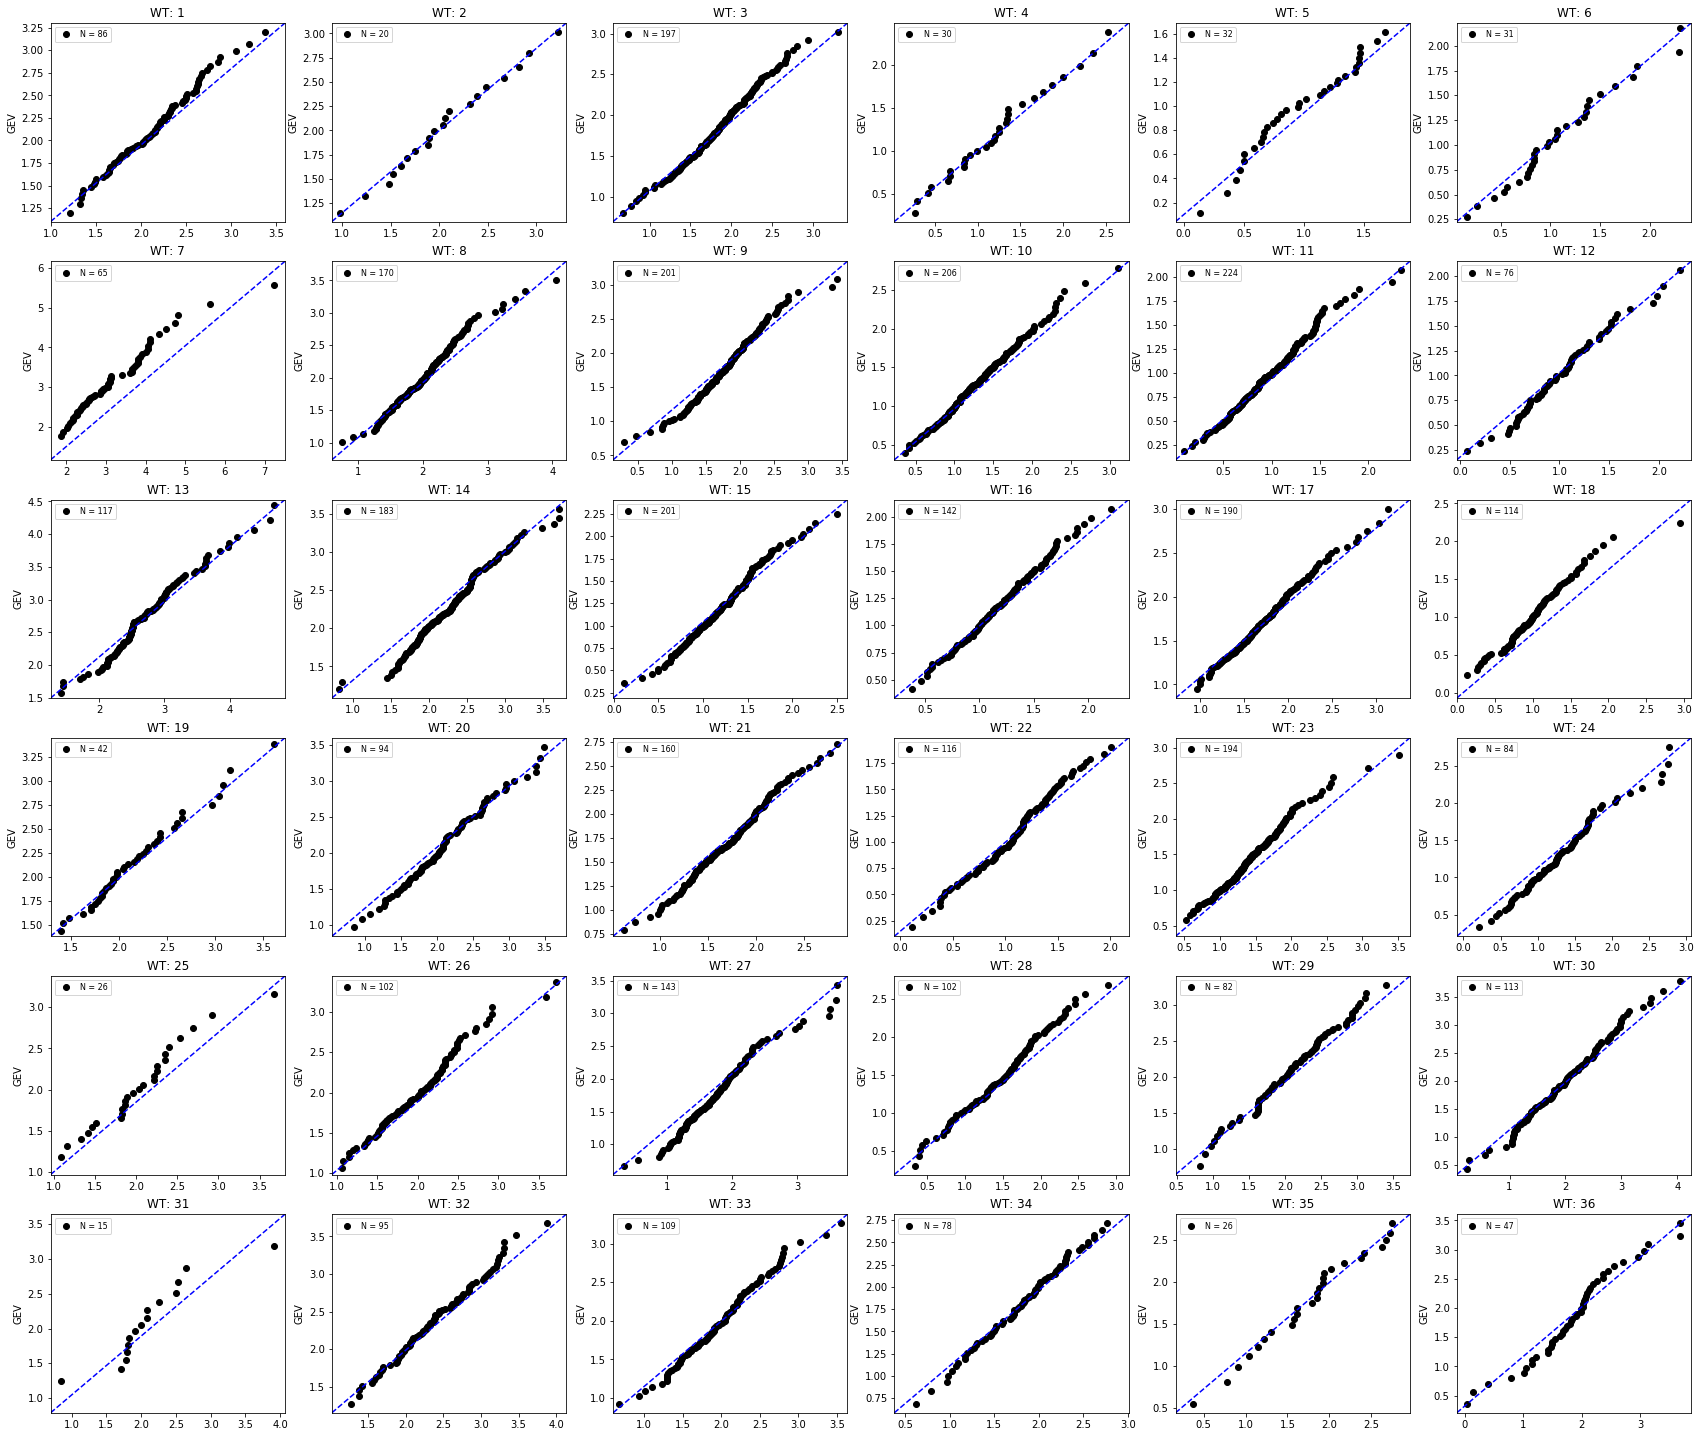

In [26]:
# GEV fit - sim comparison and QQ plot

Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=1.5,
);

Plot_Fit_QQ(
    WVS_fit_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);

# TODO
#CE.Report_Sim_GevFit(WVS_sim_p, 'swell_1_Hs') ?


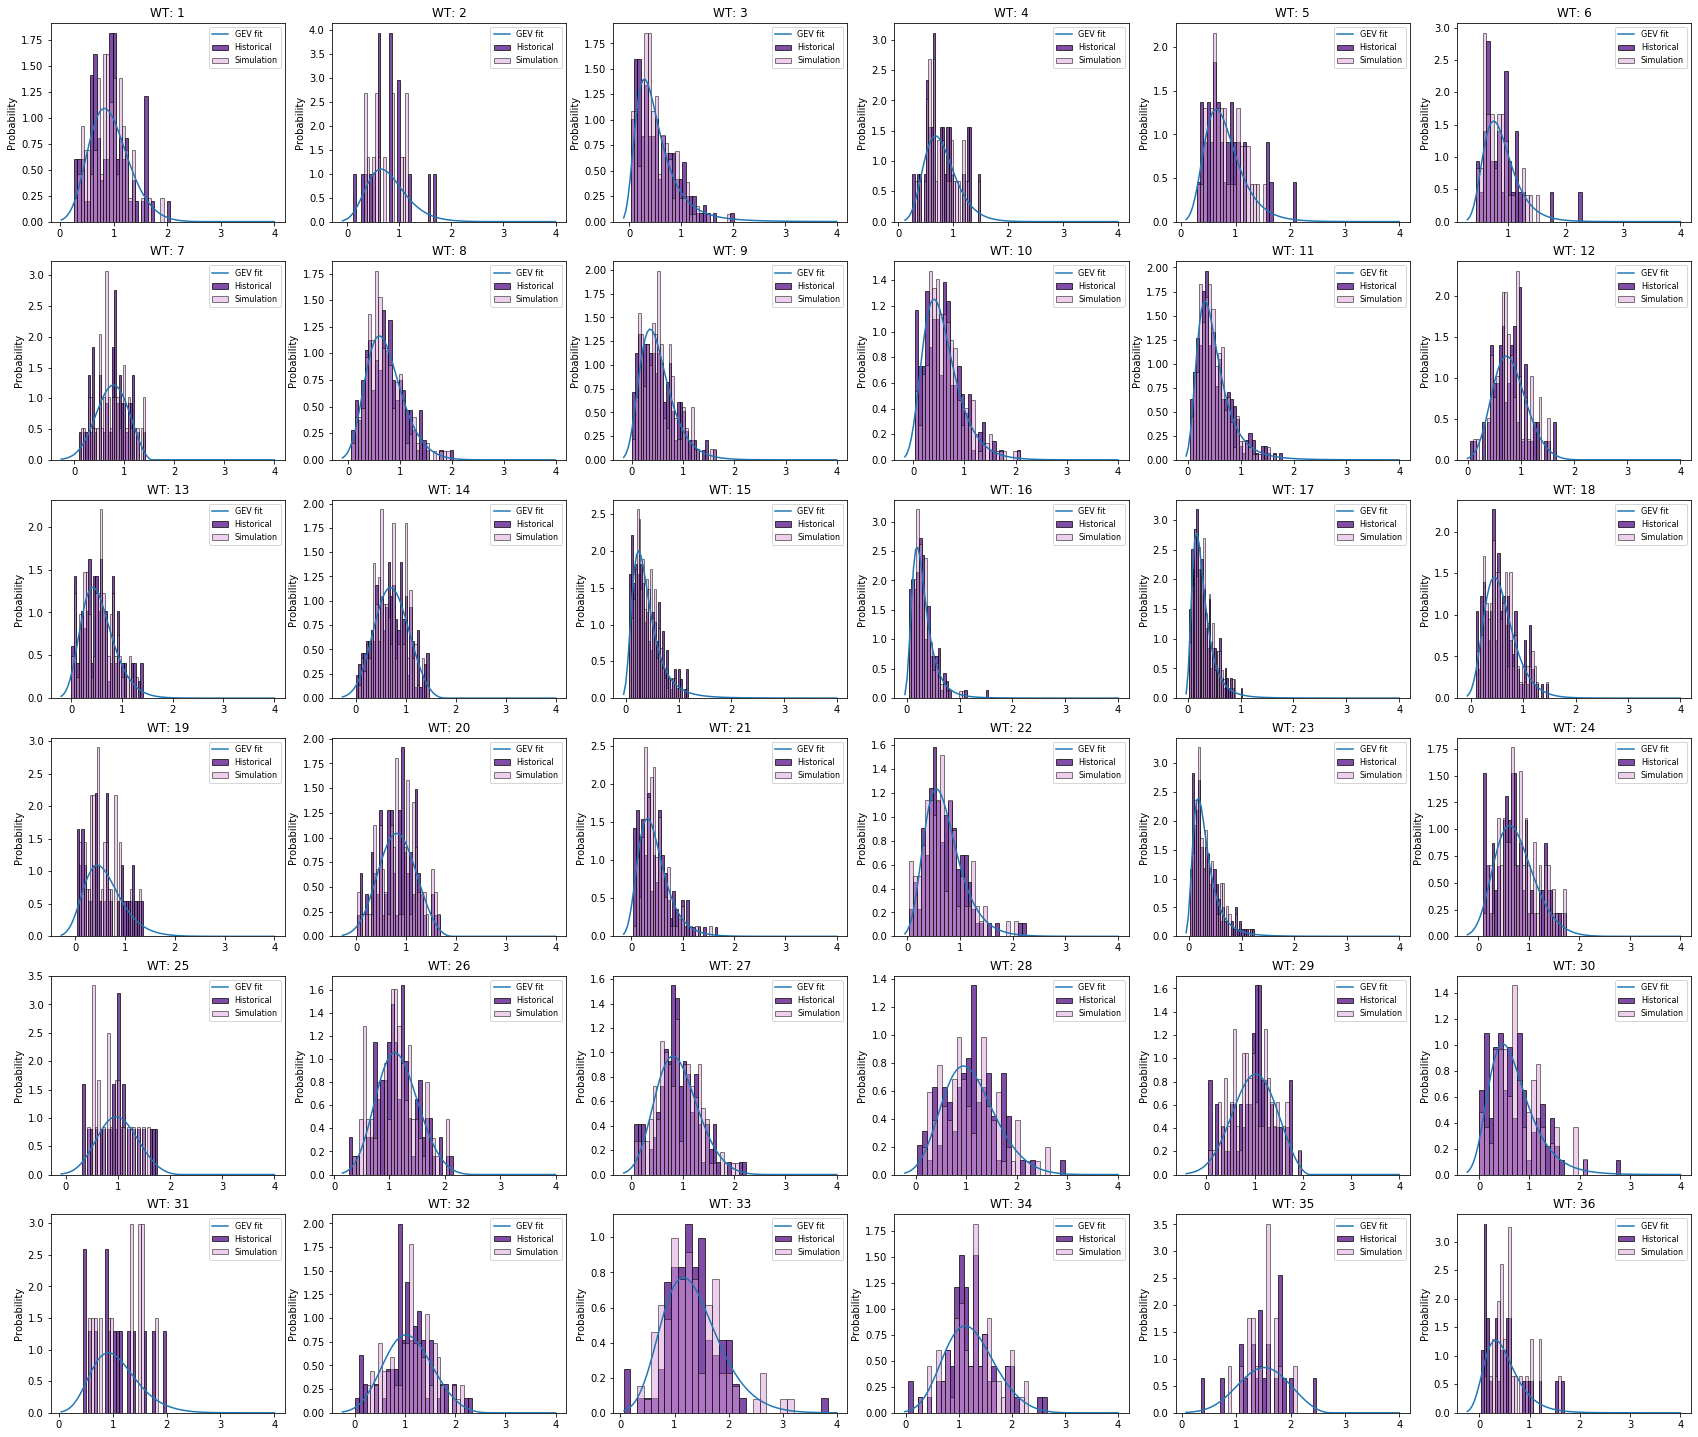

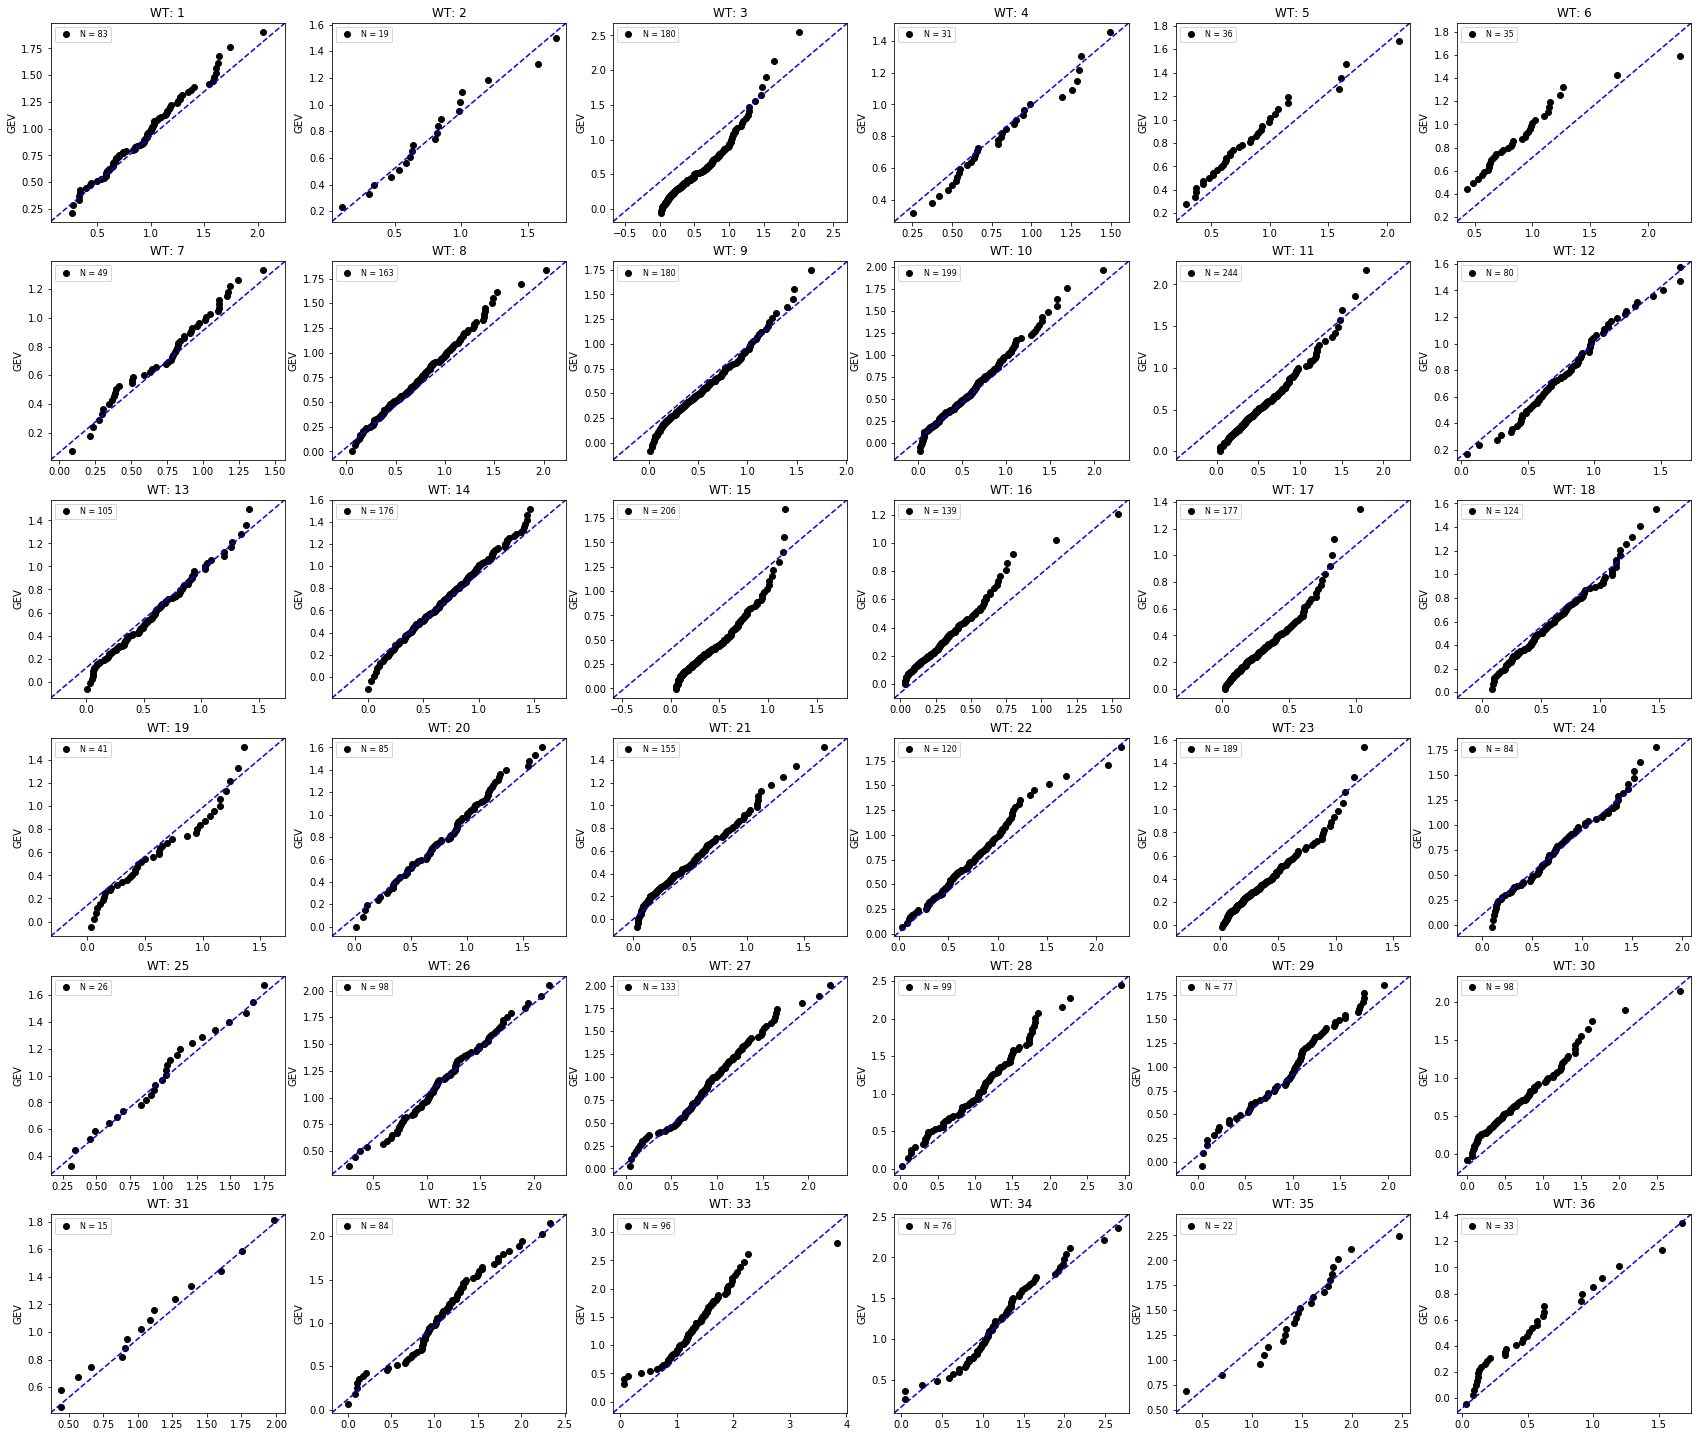

In [27]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


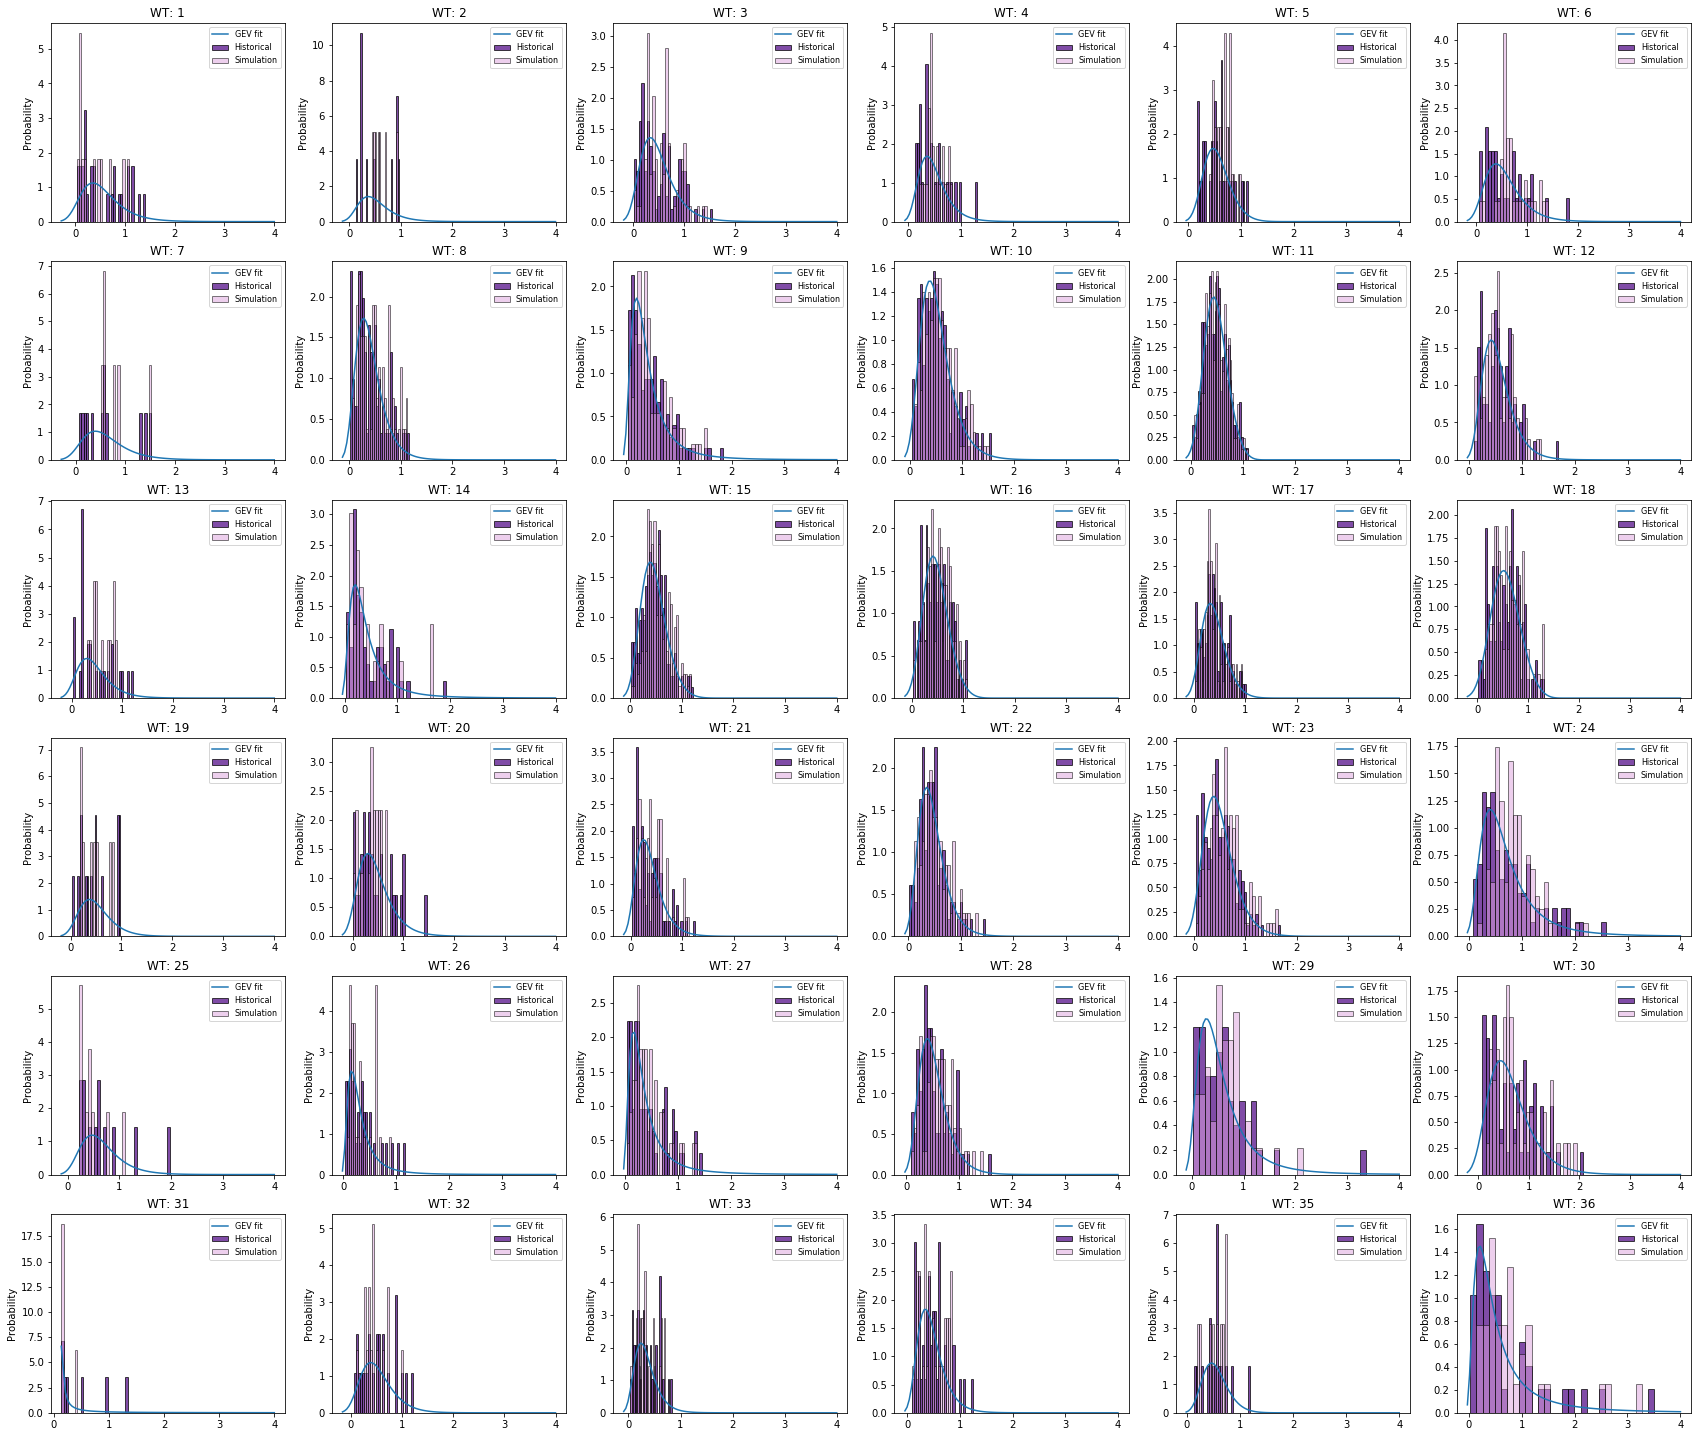

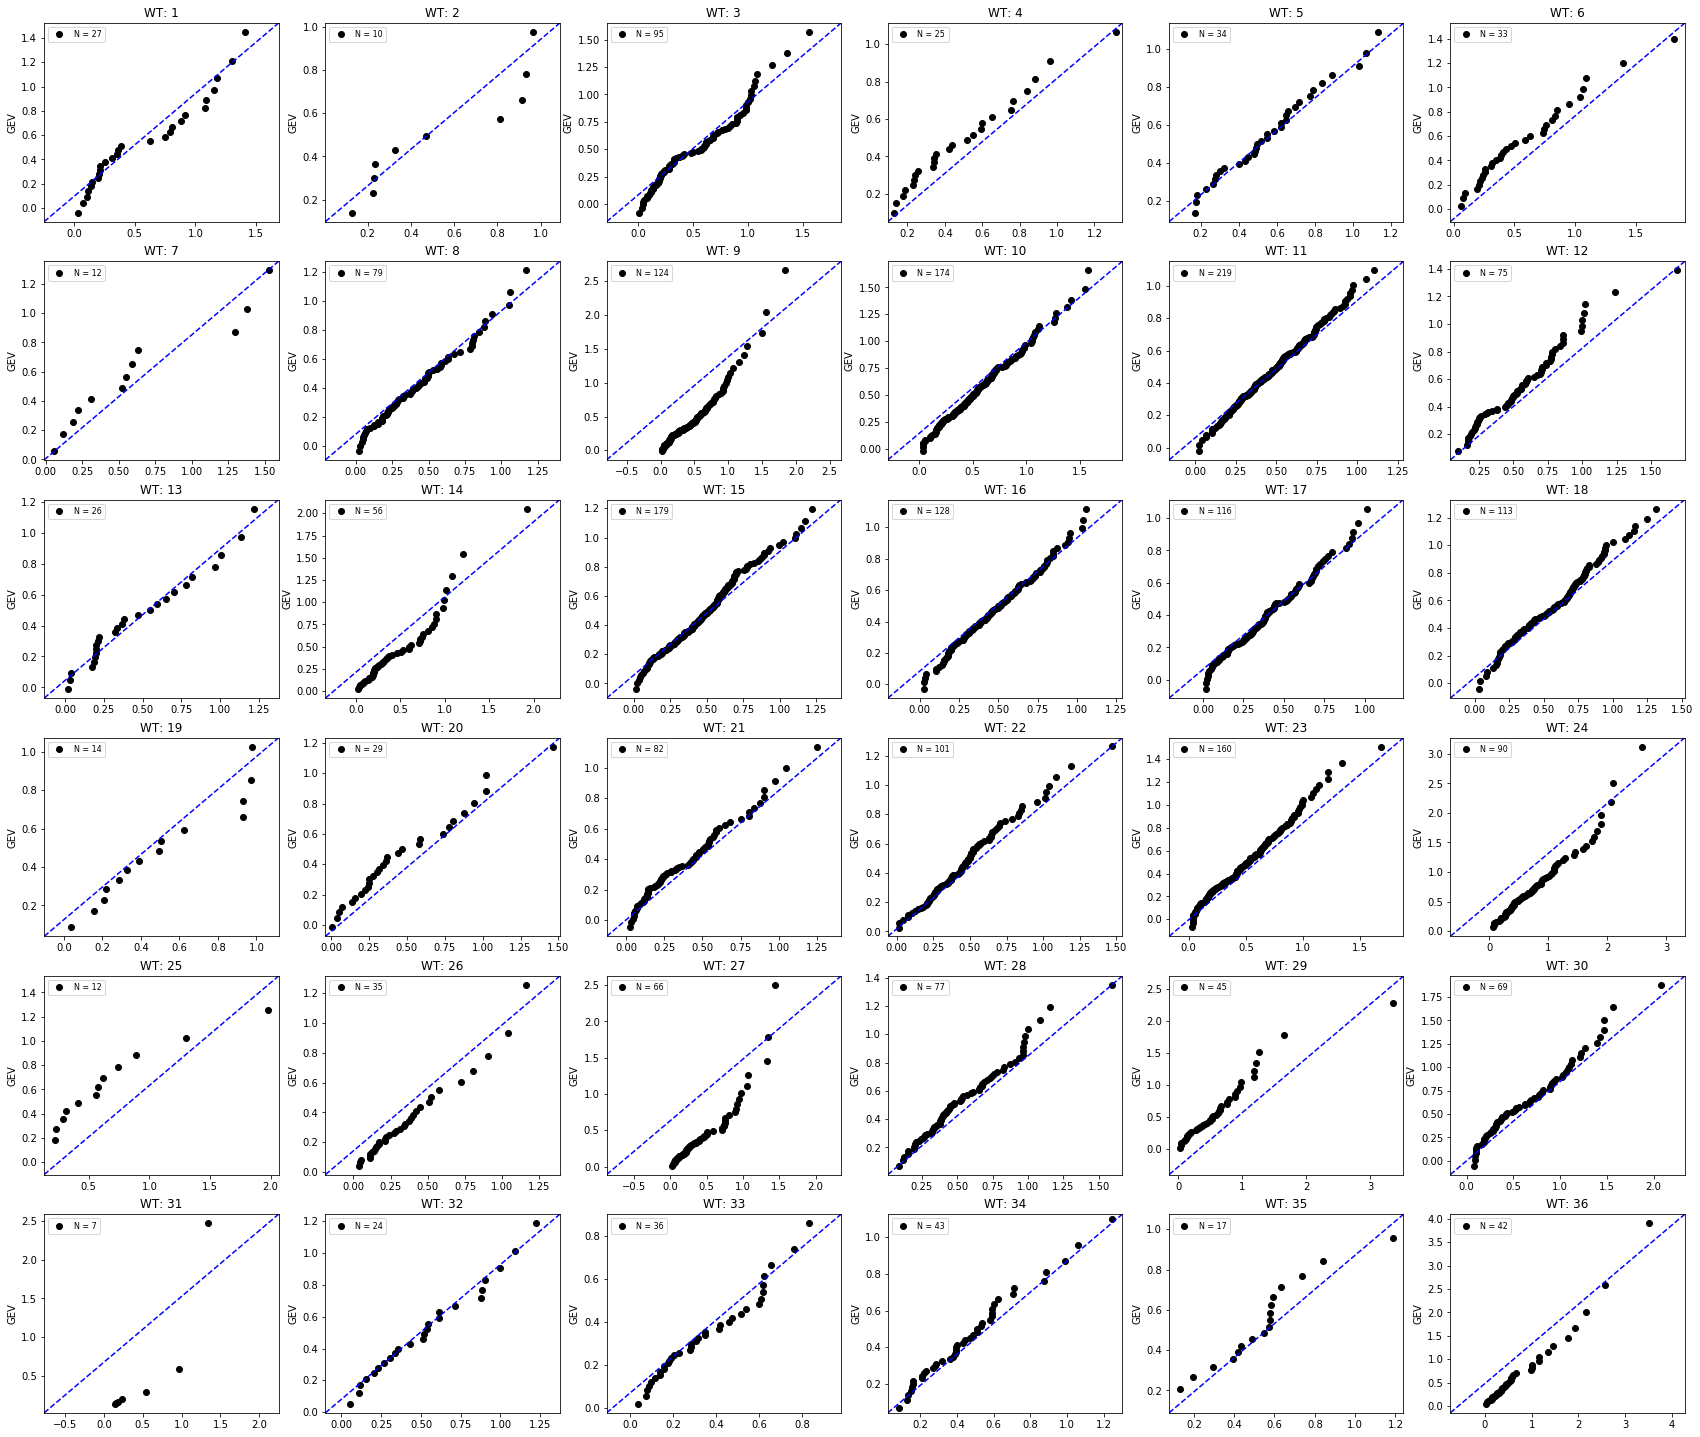

In [31]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);



## Climate Emulator Validation: Tp families

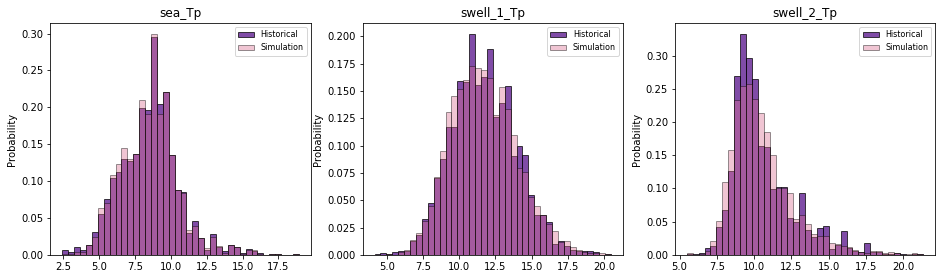

In [32]:
# waves families Tp
vvs = ['sea_Tp', 'swell_1_Tp', 'swell_2_Tp']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


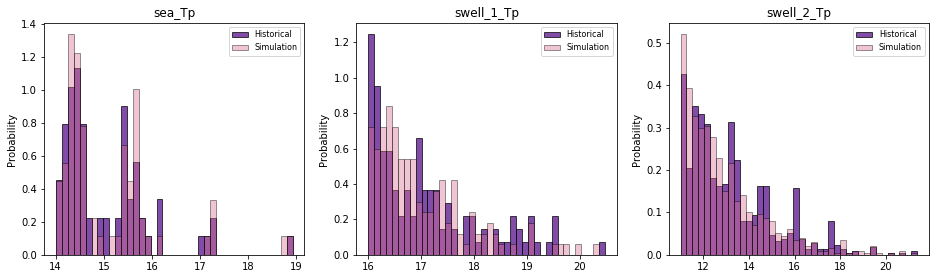

In [33]:
# plot selection
vns_lims = {
    'sea_Tp':(14, 30),
    'swell_1_Tp':(16, 30),
    'swell_2_Tp':(11, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


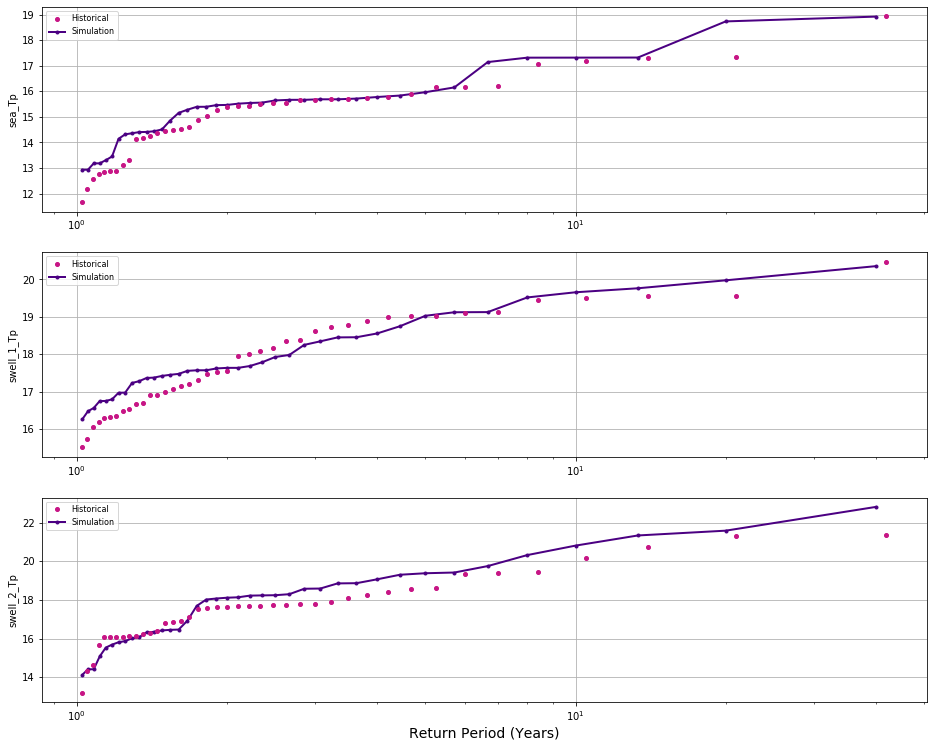

In [34]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


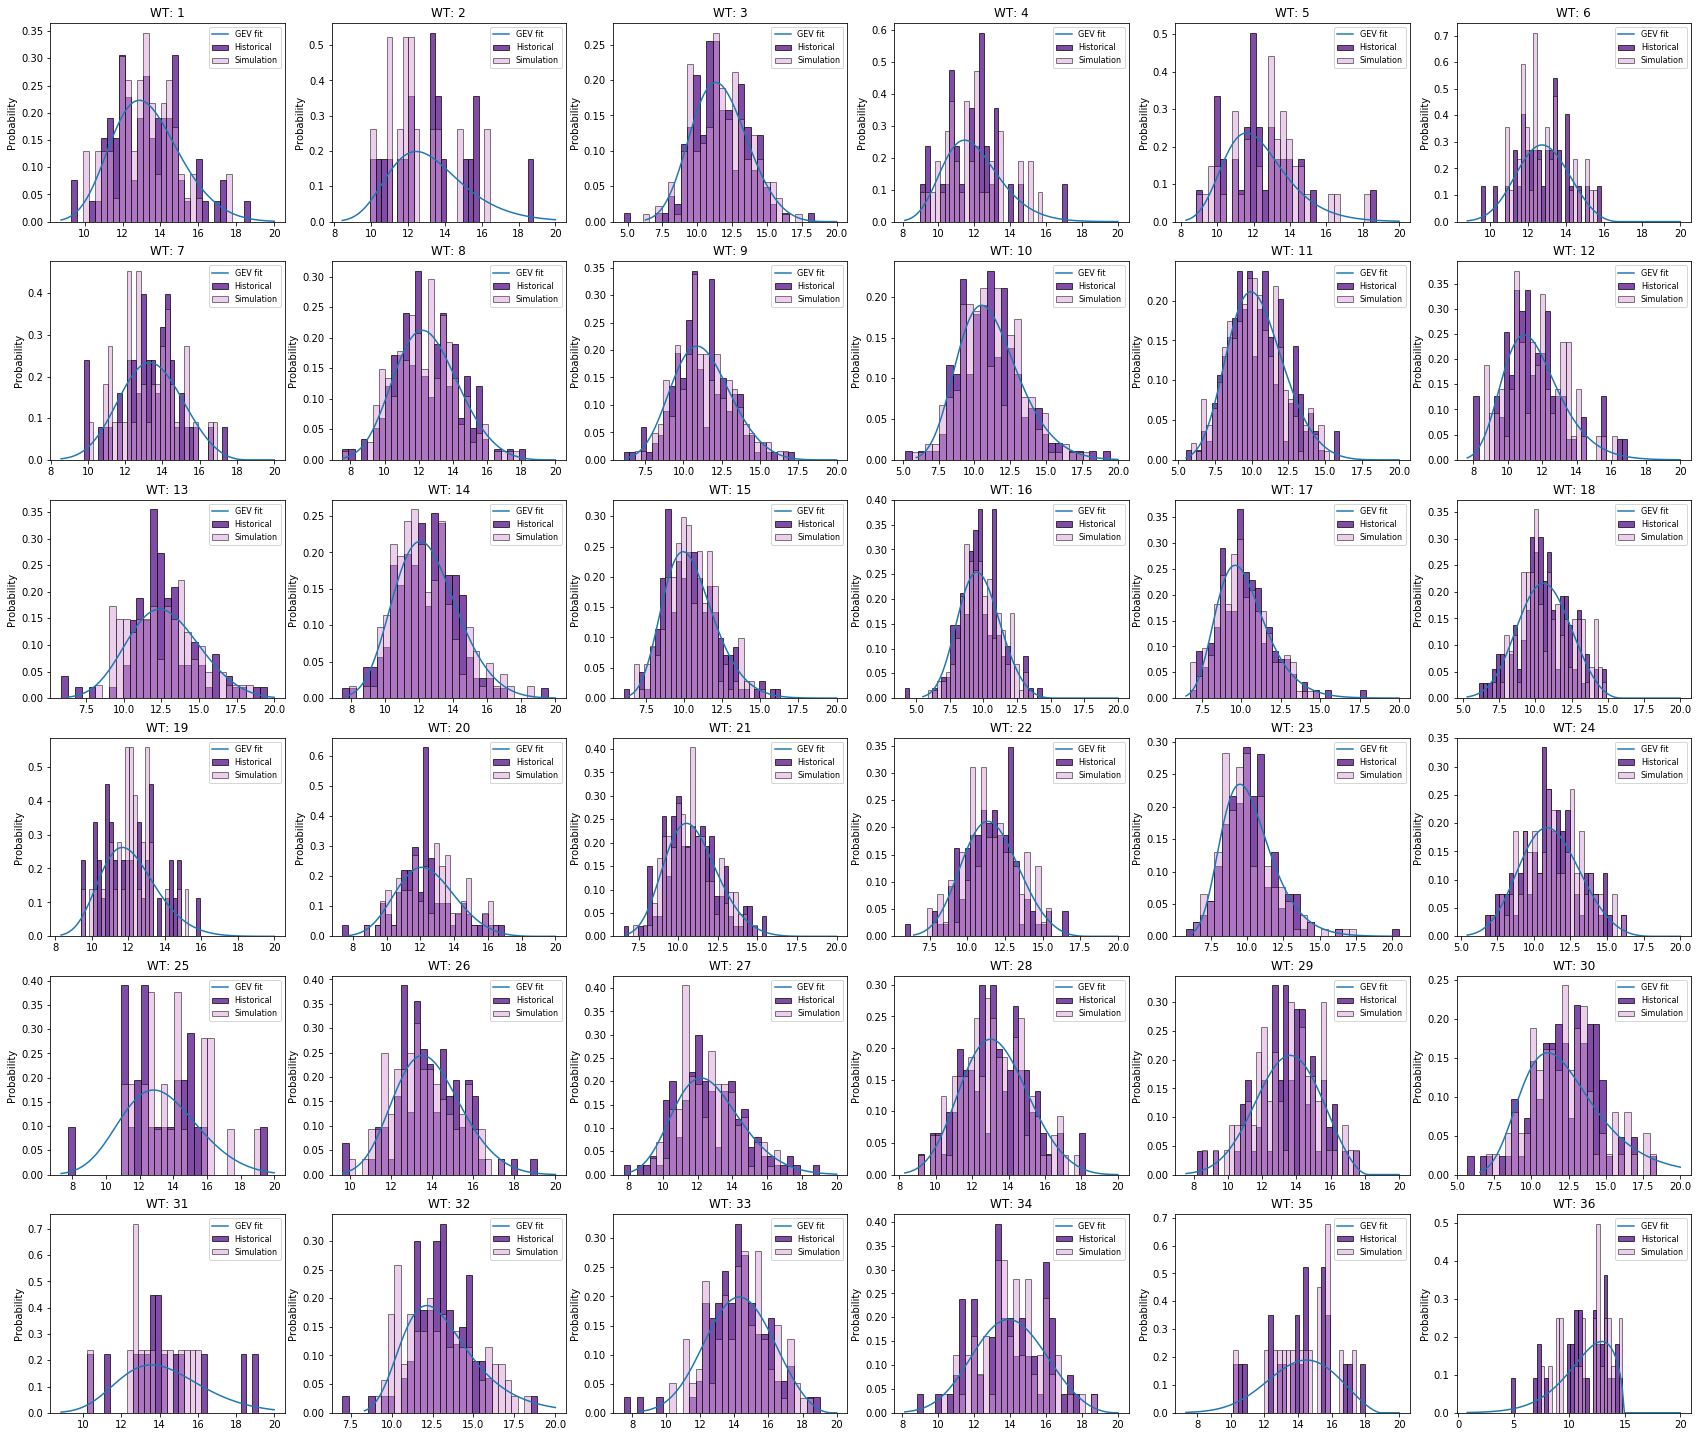

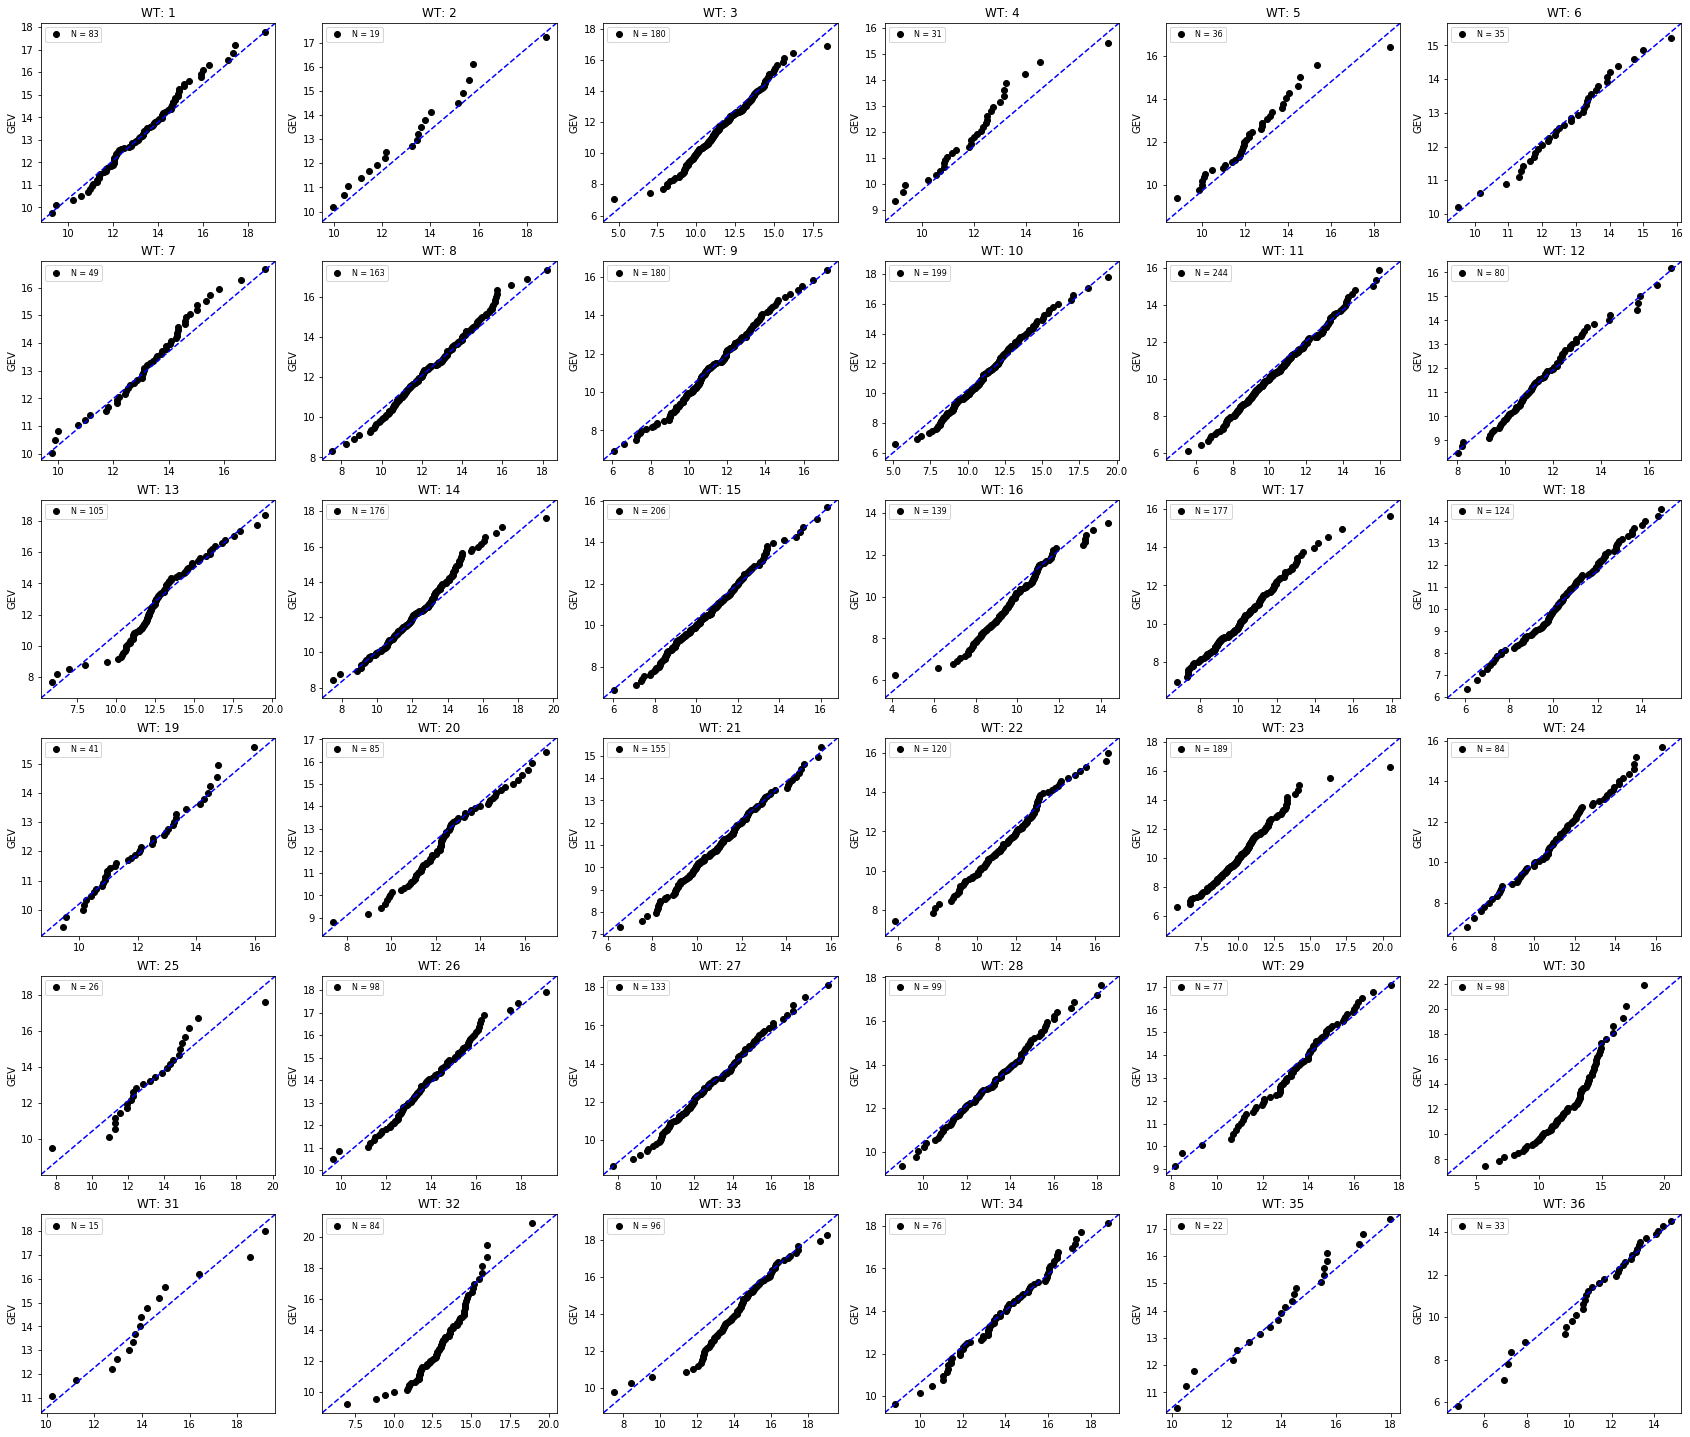

In [35]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);

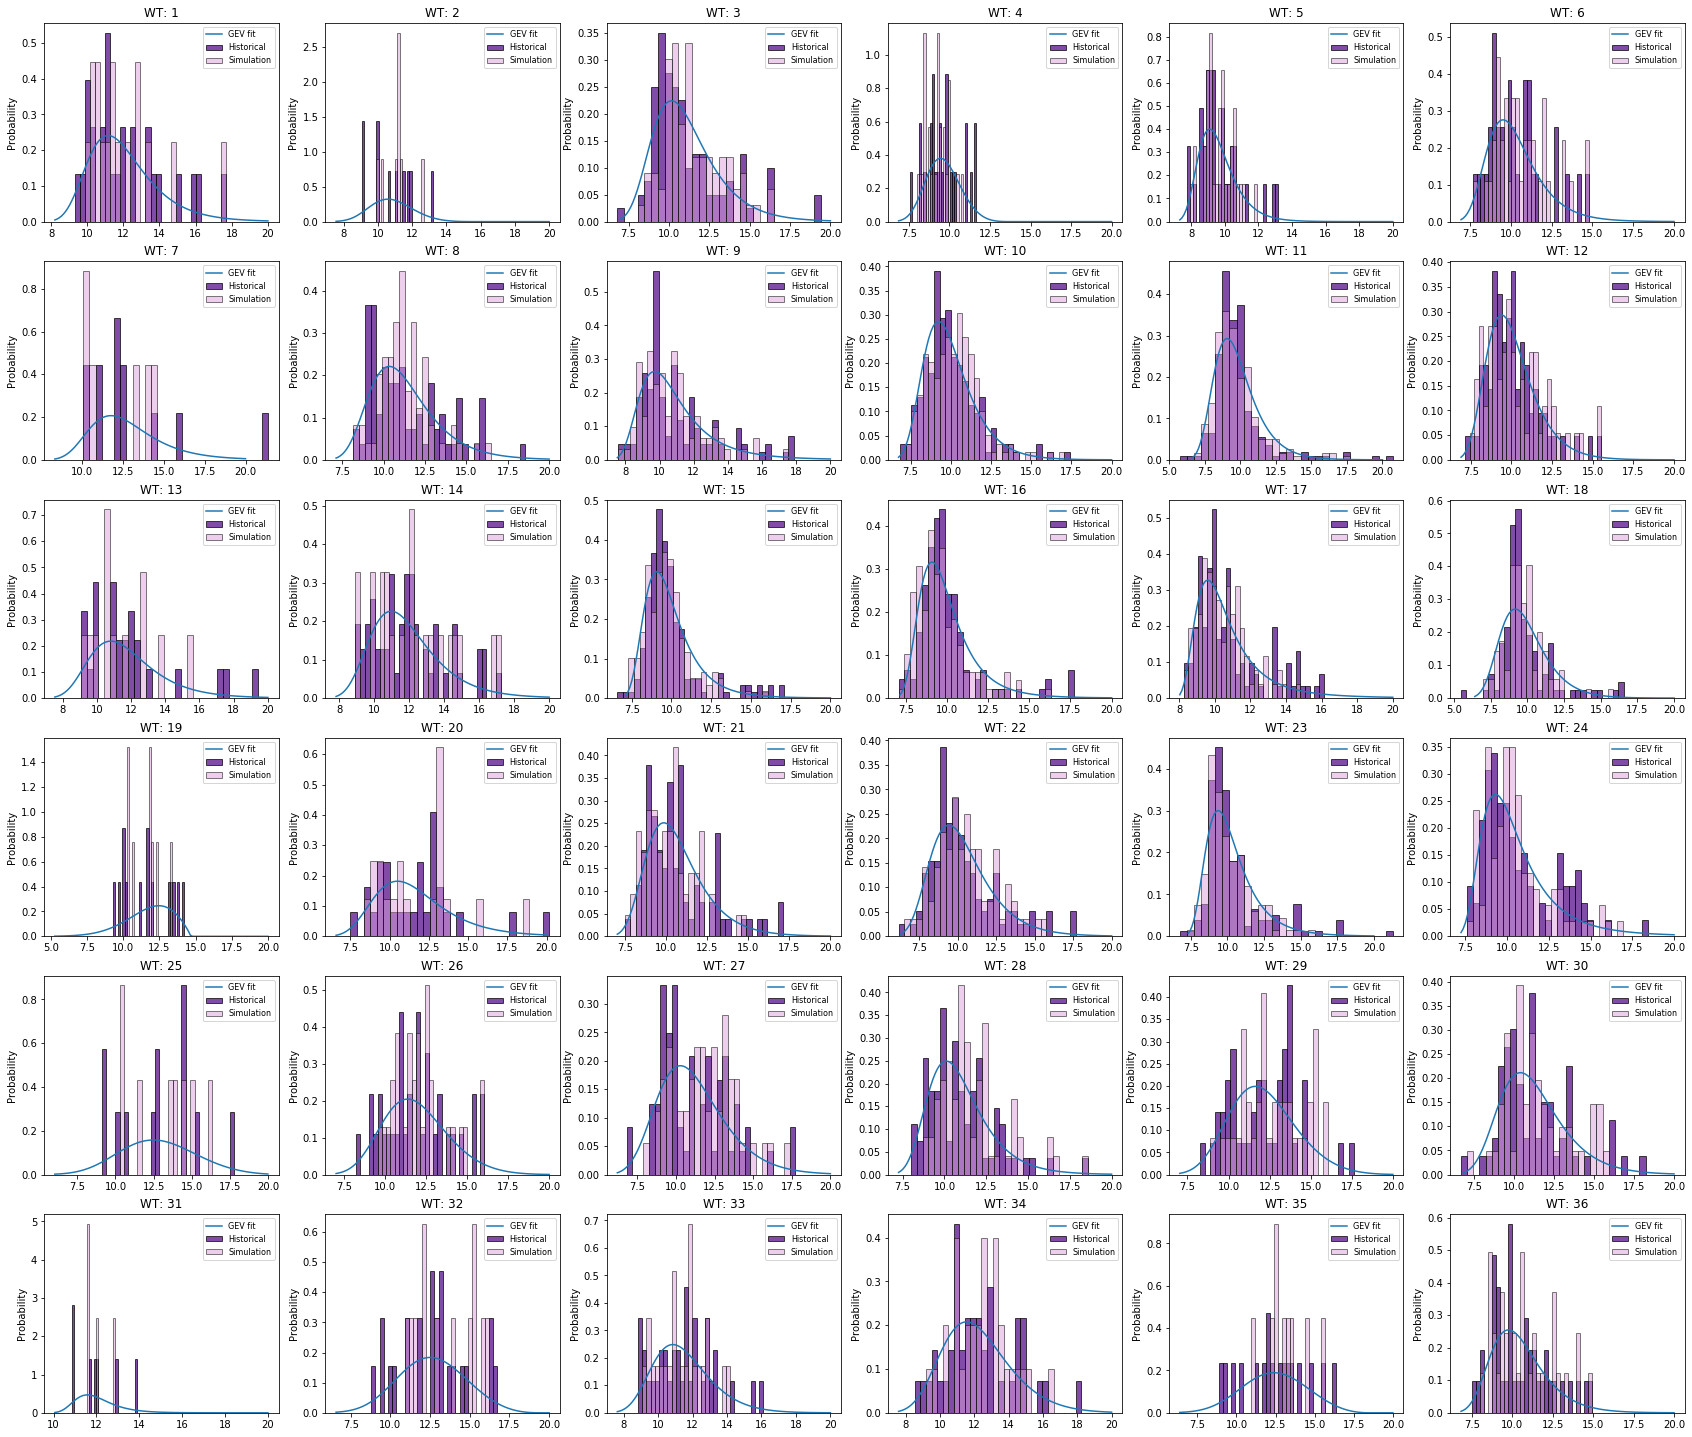

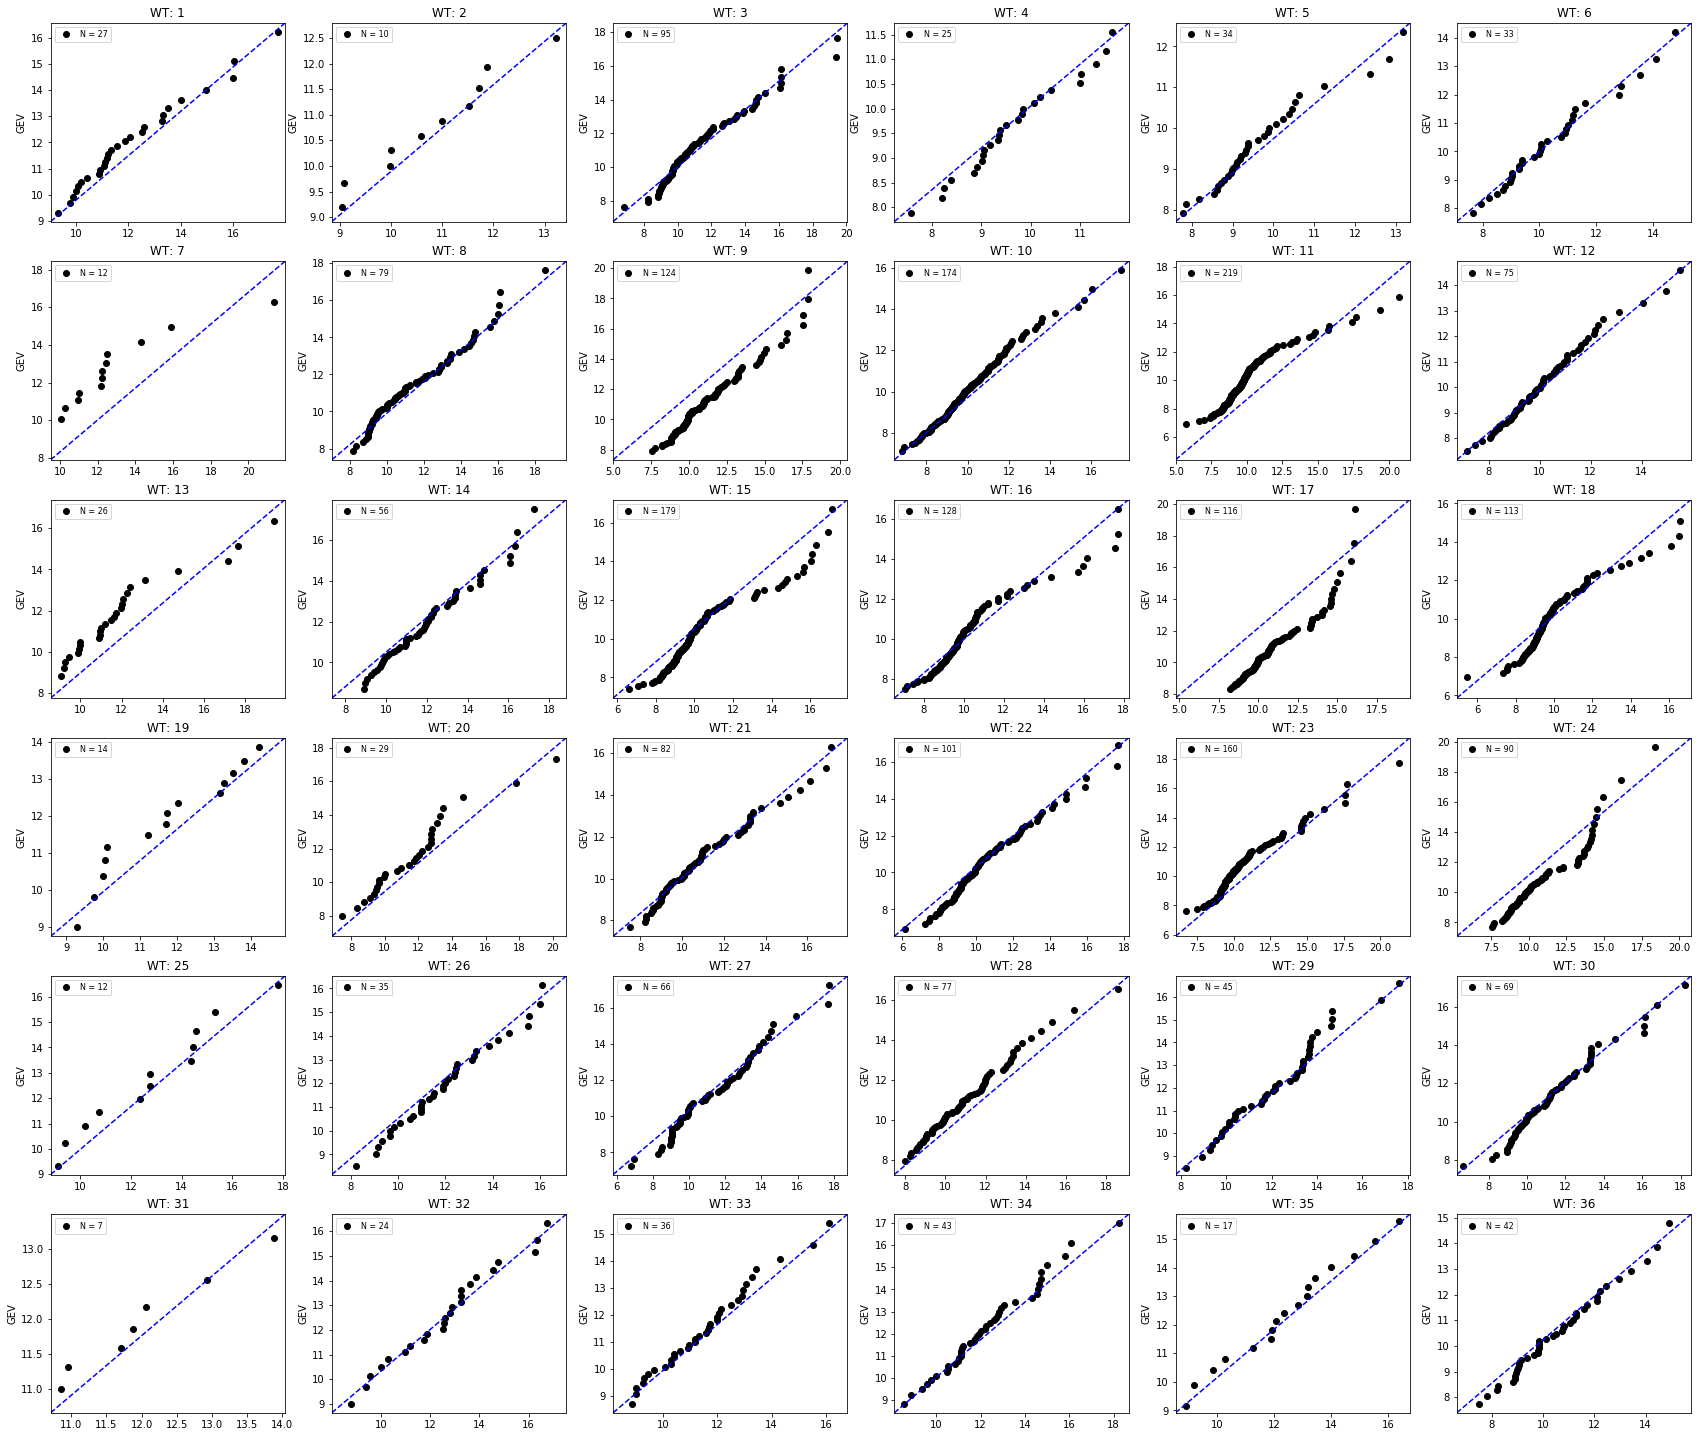

In [36]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


## Climate Emulator Validation: Aggregated Waves Hs and Tp

In [37]:

# Aggregate Waves Families
WVS_fit_agr = Aggregate_WavesFamilies(WVS_fit_p, a_tp='max_energy')
WVS_sim_agr = Aggregate_WavesFamilies(WVS_sim_p, a_tp='max_energy')

# Calculate AWL
WVS_fit_agr['AWL'] = AWL(WVS_fit_agr['Hs'], WVS_fit_agr['Tp'])
WVS_sim_agr['AWL'] = AWL(WVS_sim_agr['Hs'], WVS_sim_agr['Tp'])


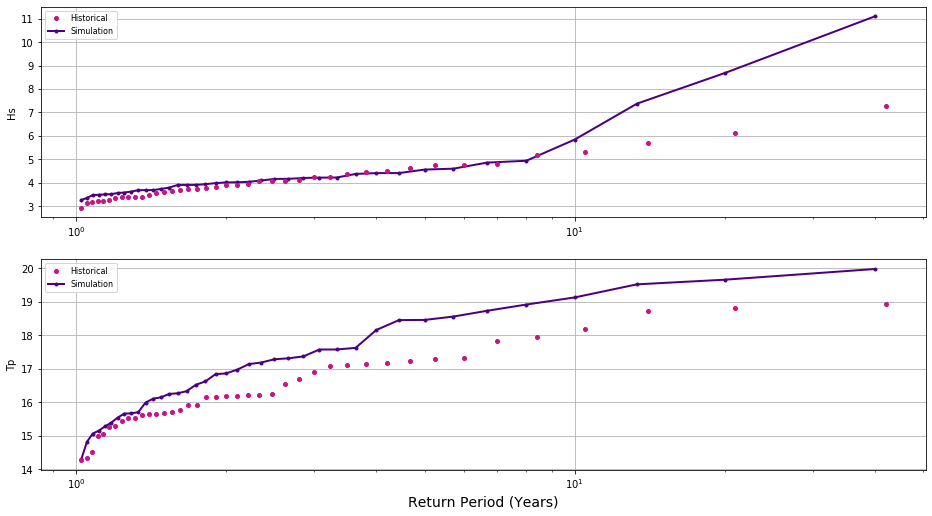

In [38]:
# Plot independent Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['Hs', 'Tp'],
    color_1='mediumvioletred', color_2='indigo',
);



## Climate Emulator Validation: AWL and marginal Hs, Tp

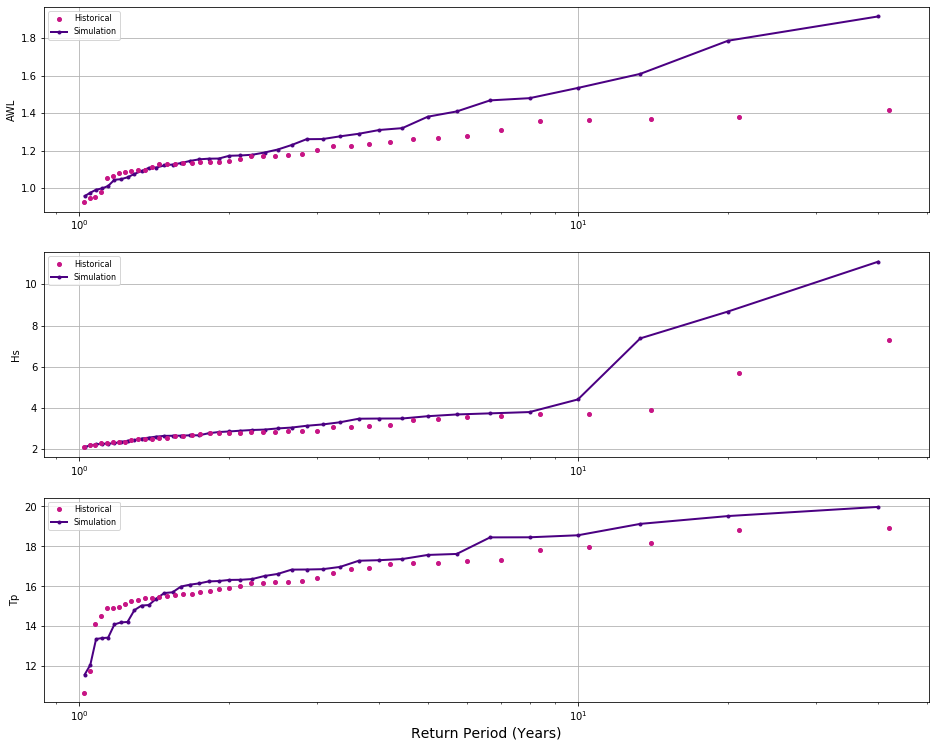

In [39]:
# TODO plot percentiles (como en nb14)

# Plot AWL and marginals (Hs, Tp) Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['AWL', 'Hs', 'Tp'], vn_max='AWL',
    color_1='mediumvioletred', color_2='indigo',
);
